In [122]:
import numpy as np
from carUtils import *
from linesUtils import *
from env import *
import glob
import tqdm
from PIL import Image

sensor_locs=Car_specs['sensor_spacing']*3.5-\
                    np.arange(Car_specs['num_sensors'])*Car_specs['sensor_spacing']
        
#load sensor data
T=[]
X=[[],[],[],[],[],[],[],[]]
for file in glob.glob("measurements/*.npy"):
    t=int(file[len("measurements\\measurment"):-4])
    raw_data=np.load(file)
    T+=[t]*raw_data.shape[0]
    for i in range(8):
        X[i]+=list(raw_data[:,i])
        #print(raw_data[:,i].shape)

X=np.array(X)
#X=X[X>0]
T=np.array(T)
line_locs=-4+T*0.2
# sensor_models=[]
# for i in range(8):
#     x=np.abs(line_locs-sensor_locs[i])

#     sensor_models.append(SensorValueModel().fit(x,X[i,:]).get_value)

# return sensor_models

In [31]:
np.min(X,axis=1)

array([412, 550, 573, 643, 549, 527, 481, 527])

In [34]:
norm_x=X.T-np.min(X,axis=1)
norm_x=norm_x*1000/np.max(norm_x,axis=0)

In [51]:
minX=np.min(X,axis=1)
maxNormX=np.max(X.T-np.min(X,axis=1),axis=0)

In [52]:
weights=np.array([4,3,2,1,-1,-2,-3,-4])

In [76]:
def sensor_fusion(sensor_Values):
    #print(((sensor_Values-minX)*1000/maxNormX))
    return np.dot(((sensor_Values-minX)*1000/maxNormX),weights)

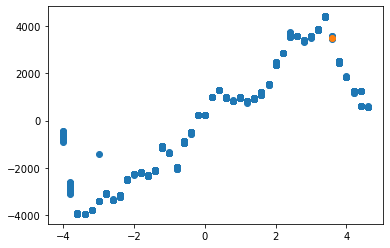

In [77]:

plt.plot(line_locs,np.dot(norm_x,weights),"o")
    
    
plt.plot(line_locs[0],sensor_fusion(X[:,0]),"o")

In [78]:
class PID:
    def __init__(self,k_p,k_d,k_i):
        
        self.k_p=k_p
        self.k_d=k_d
        self.k_i=k_i
        self.errors=[0]
        
    def forward(self,error):

        correction=self.k_p*error+self.k_d*(error-self.errors[-1])+self.k_i*(np.sum(self.errors)+error)

            
        self.errors.append(error)
        return correction
        

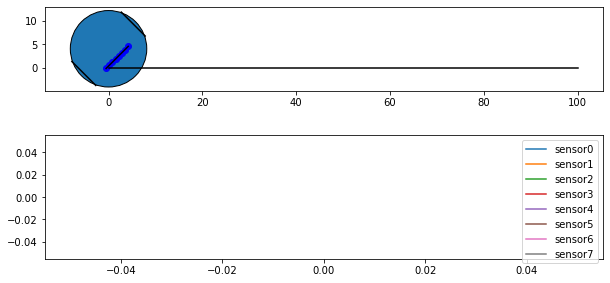

In [134]:
e=Env()
e.car.set_loc(0,4,-45)
e.plot()

In [135]:
import os
os.mkdir("PID")

In [136]:
controller=PID(-1,-4,-0.1)
base_speed=100

readings=e.move_car(base_speed,base_speed)
for i in tqdm.tqdm(range(10000)):
    error=sensor_fusion(readings)
    correction=controller.forward(error)
    readings=e.move_car(base_speed-correction,base_speed+correction)
    if i%100==0:
        e.plot("PID",f"{i}.png")

100%|████████████████████████████████████| 10000/10000 [00:31<00:00, 315.98it/s]


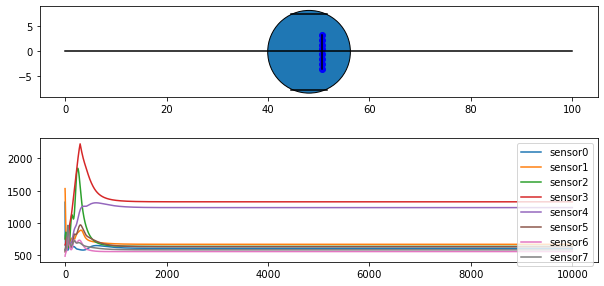

In [137]:
e.plot()

In [140]:
images=[]
for i in tqdm.tqdm(range(10000)):
    if i%100==0:
        images.append(Image.open(f"PID/{i}.png"))

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 460244.92it/s]


In [141]:
frame_one = images[0]
frame_one.save("PID.gif", format="GIF", append_images=images,
           save_all=True, duration=100, loop=0)